In [1]:
# import libraries
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, jaccard_score
import numpy as np
import os

In [2]:
area_one_pixel = (1.27/700)**2

In [6]:
def display_images(image, model_result, ground_truth):
    """
    Display the leaf image, model result, and ground truth side by side.
    
    Parameters:
    image (numpy.ndarray): The original leaf image.
    model_result (numpy.ndarray): The image produced by the model.
    ground_truth (numpy.ndarray): The ground truth image.

    Returns:
    None
    """

    plt.figure(figsize=(20, 20))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("leaf")

    plt.subplot(1, 3, 2)
    plt.imshow(model_result)
    plt.title("result")

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth)
    plt.title("ground_truth")


def format_ground_truth(ground_truth):
    """
    Format the ground truth image using specific target values.
    
    Parameters:
    ground_truth (numpy.ndarray): The ground truth image.

    Returns:
    numpy.ndarray: The formatted ground truth image.
    """

    # Define the target values for the ground truth image
    target_values = np.array([63, 127, 191, 255])

    # Define the bins for the ground truth image
    bins = np.array([0, 95, 159, 223, 255])

    # Convert the ground truth image to a 1D array
    indices = np.digitize(ground_truth, bins) - 1

    # Ensure that the indices are within the range of the target values
    valid_indices = np.where(indices < len(target_values), indices, len(target_values) - 1)

    # Create the formatted ground truth image
    ground_truth = target_values[valid_indices]

    # Convert the formatted ground truth image to the original shape
    ground_truth = ground_truth.astype(np.uint8)

    return ground_truth


def format_images(model_result, ground_truth):
    """
    Format the images by converting them to grayscale and flattening them.
    
    Parameters:
    model_result (numpy.ndarray): The image produced by the model.
    ground_truth (numpy.ndarray): The ground truth image.

    Returns:
    tuple: The formatted model result and ground truth images.
    """

    # Convert images to grayscale
    model_result = cv2.cvtColor(model_result, cv2.COLOR_RGB2GRAY)
    ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_RGB2GRAY)

    # Flatten the images
    model_result = model_result.flatten()
    ground_truth = ground_truth.flatten()

    return model_result, ground_truth


def label_metrics(ground_truth, model_result, class_label):
    """
    Calculate metrics for a specific class.
    
    Parameters:
    ground_truth (numpy.ndarray): The ground truth image.
    model_result (numpy.ndarray): The image produced by the model.
    class_label (int): The label of the class for which to calculate the metrics.

    Returns:
    tuple: The precision, recall, F1 score, and IoU for the class.
    """

    precision = precision_score(ground_truth, model_result, labels=[class_label], average=None, zero_division=1)[0]
    recall = recall_score(ground_truth, model_result, labels=[class_label], average=None, zero_division=1)[0]
    f1 = f1_score(ground_truth, model_result, labels=[class_label], average=None, zero_division=1)[0]
    iou = jaccard_score(ground_truth, model_result, labels=[class_label], average=None)[0]

    # Calculate the surface error
    ground_truth_surface = np.sum(ground_truth == class_label)
    model_result_surface = np.sum(model_result == class_label)
    surface_error_pixels = abs(ground_truth_surface - model_result_surface)

    ground_truth_surface_cm2 = ground_truth_surface * area_one_pixel
    model_result_surface_cm2 = model_result_surface * area_one_pixel
    surface_error_cm2 = abs(ground_truth_surface_cm2 - model_result_surface_cm2)


    surface_error_percent = (abs(ground_truth_surface - model_result_surface) / ground_truth_surface)*100 if ground_truth_surface > 0 else 0

    return precision, recall, f1, iou, ground_truth_surface_cm2, model_result_surface_cm2 ,surface_error_cm2, surface_error_percent


def global_metrics(ground_truth, result):
    """
    Calculate the global metrics.
    
    Parameters:
    ground_truth (numpy.ndarray): The ground truth image.
    result (numpy.ndarray): The image produced by the model.

    Returns:
    tuple: The mean average precision (mAP) and accuracy.
    """

    mAP = precision_score(ground_truth, result, average='macro', zero_division=1)
    accuracy = accuracy_score(ground_truth, result)

    return mAP, accuracy


def process_images_and_calculate_metrics(image, model_result, ground_truth):
    """
    Process the images and calculate the metrics.
    
    Parameters:
    image (numpy.ndarray): The original leaf image.
    model_result (numpy.ndarray): The image produced by the model.
    ground_truth (numpy.ndarray): The ground truth image.

    Returns:
    None
    """

    # Format the images
    model_result_reshaped = format_ground_truth(model_result)
    ground_truth_reshaped = format_ground_truth(ground_truth)

    model_result, ground_truth = format_images(model_result, ground_truth)

    # Calculate the metrics for each class
    code = {'BACKGROUND':63 ,'LEAF':127, 'RUST':255, 'OIDIUM':191}

    for class_name, class_label in code.items():
        precision, recall, f1, IoU, ground_truth_surface_cm2, model_result_surface_cm2,surface_error_cm2, surface_error_percent = label_metrics(ground_truth, model_result, class_label=class_label)
        print(f"Class: {class_name}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F1-score: {f1:.3f}")
        print(f"IoU: {IoU:.3f}")
        print(f"Ground truth surface : {ground_truth_surface_cm2:.3f} cm2")
        print(f"Model result surface : {model_result_surface_cm2:.3f} cm2")
        print(f"Surface error : {surface_error_cm2:.3f} cm2")
        print(f"Area error : {surface_error_percent:.3f} %")
        print("\n")

    # Calculate the global metrics
    mAP, accuracy = global_metrics(ground_truth, model_result)
    print(f"mAP: {mAP}")
    print(f"Accuracy: {accuracy}")

    # Reshape the images to the original shape for display
    model_result.reshape((image.shape[1], image.shape[0], 1))
    ground_truth.reshape((image.shape[1], image.shape[0], 1))

    # Display the images
    display_images(image, model_result_reshaped, ground_truth_reshaped)

Class: BACKGROUND
Precision: 0.969
Recall: 0.987
F1-score: 0.978
IoU: 0.957
Ground truth surface : 13.072 cm2
Model result surface : 13.313 cm2
Surface error : 0.241 cm2
Area error : 1.846 %


Class: LEAF
Precision: 0.980
Recall: 0.986
F1-score: 0.983
IoU: 0.966
Ground truth surface : 25.341 cm2
Model result surface : 25.505 cm2
Surface error : 0.164 cm2
Area error : 0.645 %


Class: RUST
Precision: 0.500
Recall: 0.830
F1-score: 0.624
IoU: 0.453
Ground truth surface : 0.052 cm2
Model result surface : 0.086 cm2
Surface error : 0.034 cm2
Area error : 66.130 %


Class: OIDIUM
Precision: 0.350
Recall: 0.541
F1-score: 0.425
IoU: 0.270
Ground truth surface : 0.343 cm2
Model result surface : 0.529 cm2
Surface error : 0.187 cm2
Area error : 54.428 %


mAP: 0.9799738029239425
Accuracy: 0.9666015292408888


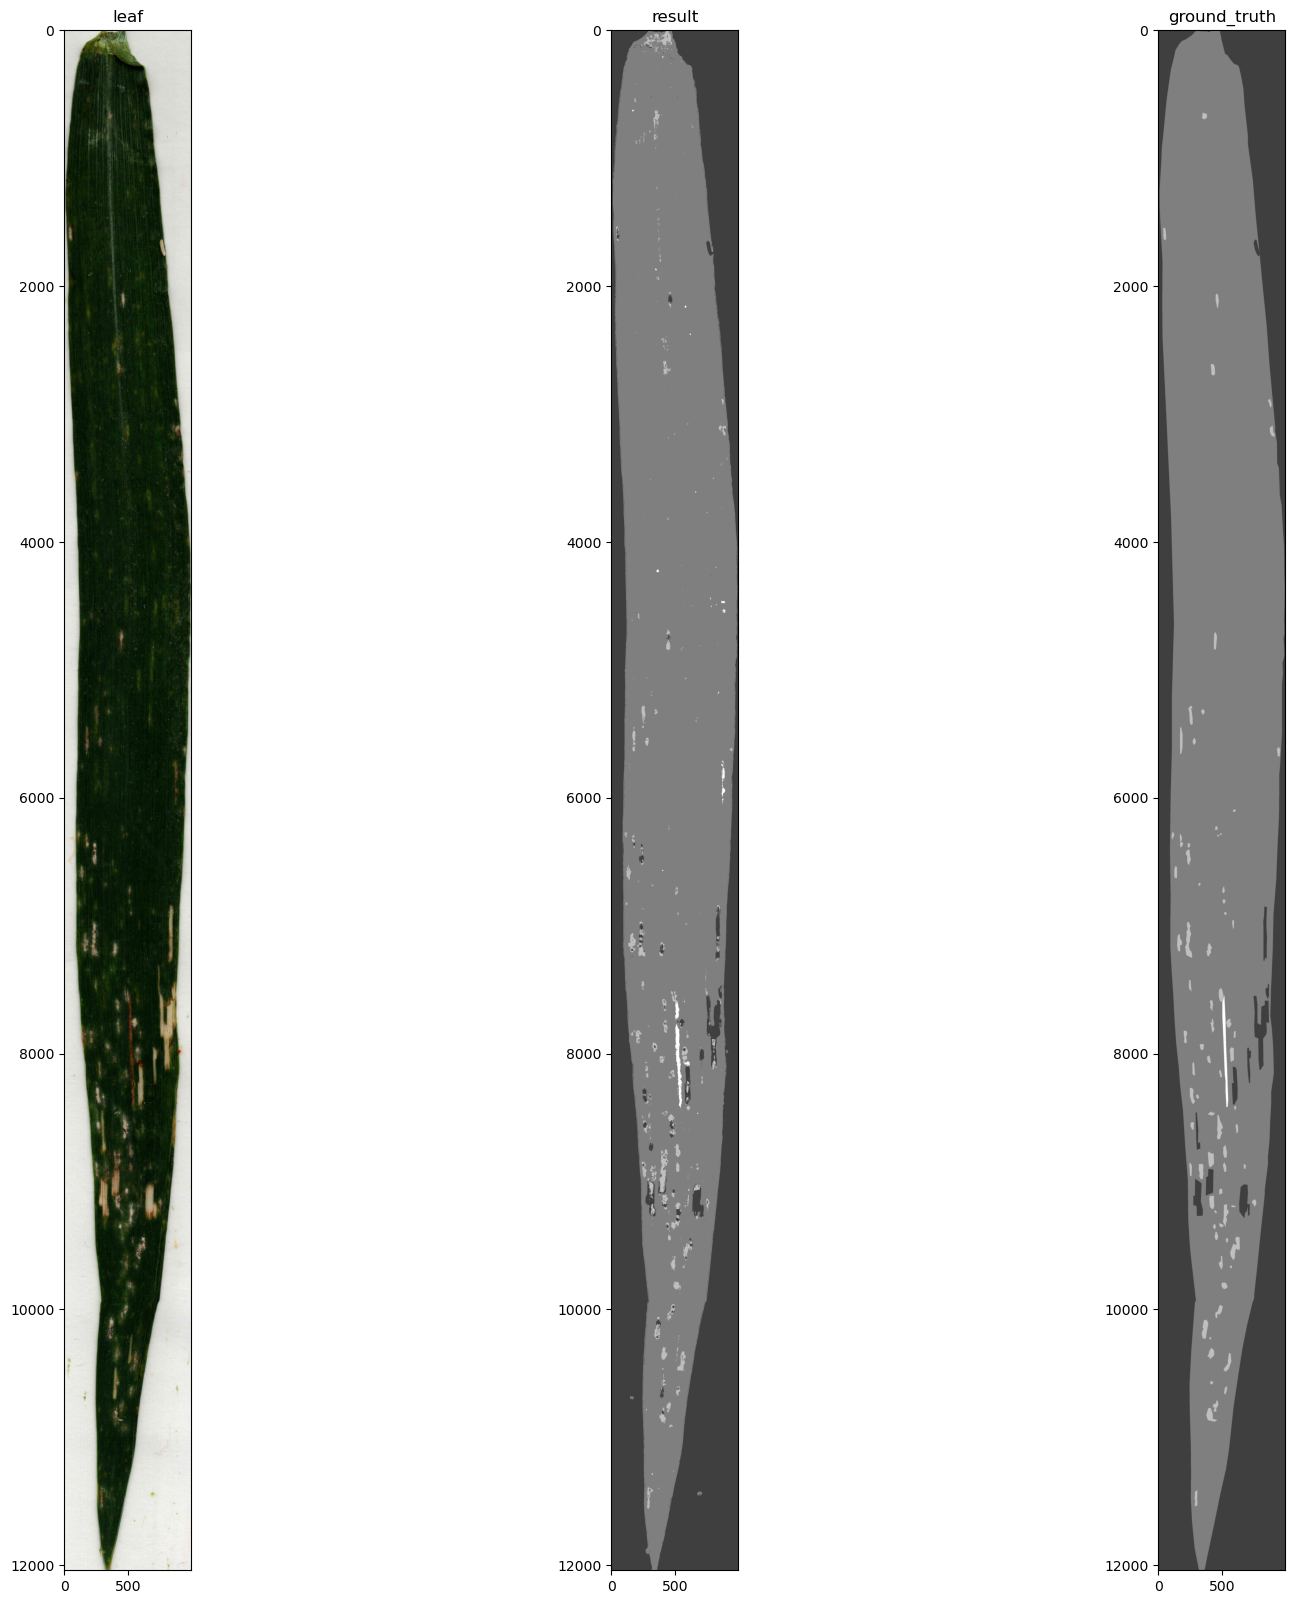

In [10]:
image_path = "test_images/654_leaf4.jpg"

# Get the name of the file without the extension
base_name = os.path.basename(image_path)
file_name, extension = os.path.splitext(base_name)


# Define the paths to the model result and ground truth images
model_result_path = os.path.join("/Users/titouanlegourrierec/Desktop/classfier_T/", f"{file_name}_Simple_Segmentation.png")
ground_truth_path = os.path.join("ground_truth/", f"{file_name}_ground_truth{extension}")

# Load the images
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

model_result = cv2.imread(model_result_path)
model_result = cv2.cvtColor(model_result, cv2.COLOR_BGR2RGB)

ground_truth = cv2.imread(ground_truth_path)
ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2RGB)

# Process the images and calculate the metrics
process_images_and_calculate_metrics(image, model_result, ground_truth)

---
# Average Metrics

In [33]:
def display_images(image, model_result, ground_truth):
    """
    Display the leaf image, model result, and ground truth side by side.
    
    Parameters:
    image (numpy.ndarray): The original leaf image.
    model_result (numpy.ndarray): The image produced by the model.
    ground_truth (numpy.ndarray): The ground truth image.

    Returns:
    None
    """

    plt.figure(figsize=(20, 20))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("leaf")

    plt.subplot(1, 3, 2)
    plt.imshow(model_result)
    plt.title("result")

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth)
    plt.title("ground_truth")


def format_ground_truth(ground_truth):
    """
    Format the ground truth image using specific target values.
    
    Parameters:
    ground_truth (numpy.ndarray): The ground truth image.

    Returns:
    numpy.ndarray: The formatted ground truth image.
    """

    # Define the target values for the ground truth image
    target_values = np.array([63, 127, 191, 255])

    # Define the bins for the ground truth image
    bins = np.array([0, 95, 159, 223, 255])

    # Convert the ground truth image to a 1D array
    indices = np.digitize(ground_truth, bins) - 1

    # Ensure that the indices are within the range of the target values
    valid_indices = np.where(indices < len(target_values), indices, len(target_values) - 1)

    # Create the formatted ground truth image
    ground_truth = target_values[valid_indices]

    # Convert the formatted ground truth image to the original shape
    ground_truth = ground_truth.astype(np.uint8)

    return ground_truth


def format_images(model_result, ground_truth):
    """
    Format the images by converting them to grayscale and flattening them.
    
    Parameters:
    model_result (numpy.ndarray): The image produced by the model.
    ground_truth (numpy.ndarray): The ground truth image.

    Returns:
    tuple: The formatted model result and ground truth images.
    """

    # Convert images to grayscale
    model_result = cv2.cvtColor(model_result, cv2.COLOR_RGB2GRAY)
    ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_RGB2GRAY)

    # Flatten the images
    model_result = model_result.flatten()
    ground_truth = ground_truth.flatten()

    return model_result, ground_truth


def label_metrics(ground_truth, model_result, class_label):
    """
    Calculate metrics for a specific class.
    
    Parameters:
    ground_truth (numpy.ndarray): The ground truth image.
    model_result (numpy.ndarray): The image produced by the model.
    class_label (int): The label of the class for which to calculate the metrics.

    Returns:
    tuple: The precision, recall, F1 score, and IoU for the class.
    """

    precision = precision_score(ground_truth, model_result, labels=[class_label], average=None, zero_division=1)[0]
    recall = recall_score(ground_truth, model_result, labels=[class_label], average=None, zero_division=1)[0]
    f1 = f1_score(ground_truth, model_result, labels=[class_label], average=None, zero_division=1)[0]
    iou = jaccard_score(ground_truth, model_result, labels=[class_label], average=None)[0]

    # Calculate the surface error
    ground_truth_surface = np.sum(ground_truth == class_label)
    model_result_surface = np.sum(model_result == class_label)
    surface_error_pixels = abs(ground_truth_surface - model_result_surface)

    ground_truth_surface_cm2 = ground_truth_surface * area_one_pixel
    model_result_surface_cm2 = model_result_surface * area_one_pixel
    surface_error_cm2 = abs(ground_truth_surface_cm2 - model_result_surface_cm2)


    surface_error_percent = (abs(ground_truth_surface - model_result_surface) / ground_truth_surface)*100 if ground_truth_surface > 0 else 0

    return precision, recall, f1, iou, ground_truth_surface_cm2, model_result_surface_cm2 ,surface_error_cm2, surface_error_percent


def global_metrics(ground_truth, result):
    """
    Calculate the global metrics.
    
    Parameters:
    ground_truth (numpy.ndarray): The ground truth image.
    result (numpy.ndarray): The image produced by the model.

    Returns:
    tuple: The mean average precision (mAP) and accuracy.
    """

    mAP = precision_score(ground_truth, result, average='macro', zero_division=1)
    accuracy = accuracy_score(ground_truth, result)

    return mAP, accuracy


def process_images_and_calculate_metrics(image, model_result, ground_truth):
    """
    Process the images and calculate the metrics.
    
    Parameters:
    image (numpy.ndarray): The original leaf image.
    model_result (numpy.ndarray): The image produced by the model.
    ground_truth (numpy.ndarray): The ground truth image.

    Returns:
    None
    """

    # Format the images
    model_result_reshaped = format_ground_truth(model_result)
    ground_truth_reshaped = format_ground_truth(ground_truth)

    model_result, ground_truth = format_images(model_result, ground_truth)

    # Initialize an empty list to store the metrics
    metrics = []

    # Calculate the metrics for each class
    #code = {'BACKGROUND':63 ,'LEAF':127, 'RUST':255, 'OIDIUM':191} #TITOUAN
    code = {'BACKGROUND':255 ,'LEAF':191, 'RUST':63, 'OIDIUM':127} #LENA

    for class_name, class_label in code.items():
        precision, recall, f1, IoU, ground_truth_surface_cm2, model_result_surface_cm2,surface_error_cm2, surface_error_percent = label_metrics(ground_truth, model_result, class_label=class_label)
        
        # Append the metrics for the current class to the list
        metrics.append([class_name, precision, recall, f1, IoU, ground_truth_surface_cm2, model_result_surface_cm2, surface_error_cm2, surface_error_percent])

    return metrics

In [34]:
images = ["test_images/111_leaf2.jpg", "test_images/654_leaf4.jpg", "test_images/664_leaf3.jpg", "test_images/672_leaf2.jpg", "test_images/684_leaf3.jpg"]

# Initialize dictionaries to store the sum of each metric for each class and the count of each class
metrics_sum = { 'precision': {}, 'recall': {}, 'f1': {}, 'IoU': {}, 'ground_truth_surface_cm2': {}, 'model_result_surface_cm2': {}, 'surface_error_cm2': {}, 'surface_error_percent': {} }
count = { 'precision': {}, 'recall': {}, 'f1': {}, 'IoU': {}, 'ground_truth_surface_cm2': {}, 'model_result_surface_cm2': {}, 'surface_error_cm2': {}, 'surface_error_percent': {} }

for image_path in images:
    # Get the name of the file without the extension
    base_name = os.path.basename(image_path)
    file_name, extension = os.path.splitext(base_name)

    # Define the paths to the model result and ground truth images
    model_result_path = os.path.join("/Users/titouanlegourrierec/Desktop/lena_segment/", f"{file_name}_Simple_Segmentation.png")
    ground_truth_path = os.path.join("/Users/titouanlegourrierec/Desktop/lena_truth/", f"{file_name}_ground_truth{extension}")

    # Load the images
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    model_result = cv2.imread(model_result_path)
    model_result = cv2.cvtColor(model_result, cv2.COLOR_BGR2RGB)

    ground_truth = cv2.imread(ground_truth_path)
    ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2RGB)

    # Process the images and calculate the metrics
    metrics = process_images_and_calculate_metrics(image, model_result, ground_truth)

    # Add the metrics to the sum and increment the count for each class
    for class_metrics in metrics:
        class_name = class_metrics[0]
        metrics_values = class_metrics[1:]
        
        for metric, value in zip(['precision', 'recall', 'f1', 'IoU', 'ground_truth_surface_cm2', 'model_result_surface_cm2', 'surface_error_cm2', 'surface_error_percent'], metrics_values):
            if metric in ['precision', 'recall', 'f1'] and (value == 0 or value == 1):
                continue
            if class_name not in metrics_sum[metric]:
                metrics_sum[metric][class_name] = value
                count[metric][class_name] = 1
            else:
                metrics_sum[metric][class_name] += value
                count[metric][class_name] += 1

# Calculate the average of each metric for each class
average_metrics = { metric: { class_name: value / count[metric][class_name] for class_name, value in class_values.items() } for metric, class_values in metrics_sum.items() }

# Now, 'average_metrics' is a dictionary where the keys are the metric names and the values are dictionaries with the class names as keys and the average metrics for each class as values
for metric, class_values in average_metrics.items():
    print("\n")
    for class_name, average_value in class_values.items():
        print(f"Average {metric} for {class_name}: {average_value}")



Average precision for BACKGROUND: 0.9764616286870138
Average precision for LEAF: 0.9671914697396181
Average precision for RUST: 0.4936241183996322
Average precision for OIDIUM: 0.49974896812535724


Average recall for BACKGROUND: 0.986580893957635
Average recall for LEAF: 0.953552593381924
Average recall for RUST: 0.9155634546960498
Average recall for OIDIUM: 0.614008723260815


Average f1 for BACKGROUND: 0.9814794243053496
Average f1 for LEAF: 0.9599672161410261
Average f1 for RUST: 0.634530943195743
Average f1 for OIDIUM: 0.5461242317973469


Average IoU for BACKGROUND: 0.9637381119023816
Average IoU for LEAF: 0.9234370536304775
Average IoU for RUST: 0.2849294941831663
Average IoU for OIDIUM: 0.3135340015392001


Average ground_truth_surface_cm2 for BACKGROUND: 13.930072863959182
Average ground_truth_surface_cm2 for LEAF: 19.070823609428572
Average ground_truth_surface_cm2 for RUST: 0.8925801766530613
Average ground_truth_surface_cm2 for OIDIUM: 0.4194757904081633


Average model_r